In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from keras.utils.np_utils import to_categorical
import glob
from collections import Counter
%matplotlib inline

Using TensorFlow backend.


## Load Images

In [2]:
data_train = np.load('input/train-resnet-features.npy').item()
X_train = np.stack(data_train.values())

Y_train = [file.split('/')[1] for file in data_train.keys()]
le = preprocessing.LabelEncoder()
le.fit(Y_train)
Y_train = to_categorical(le.transform(Y_train), num_classes = 98)
Y_train == np.stack(Y_train)

data_test = np.load('input/val-resnet-features.npy').item()
X_test = np.stack(data_test.values())

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train,test_size=0.2, random_state=12)

In [3]:
from keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D,
    Flatten, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, add)
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


In [11]:
model = Sequential()
model.add(Dense(1000, input_shape=(2048,),activation='relu'))
model.add(Dense(98, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.000001)

In [13]:
history = model.fit(x=X_train, y=Y_train,
                    validation_data = (X_valid, Y_valid),
                    epochs = 512, 
                    batch_size=128,
                    verbose = 2,
                    callbacks=[learning_rate_reduction,early_stopping]
                  )

Train on 4168 samples, validate on 1043 samples
Epoch 1/512
 - 2s - loss: 4.6574 - acc: 0.0506 - val_loss: 4.0117 - val_acc: 0.0815
Epoch 2/512
 - 2s - loss: 3.4256 - acc: 0.1507 - val_loss: 3.5846 - val_acc: 0.1294
Epoch 3/512
 - 2s - loss: 2.9819 - acc: 0.2409 - val_loss: 3.3769 - val_acc: 0.1697
Epoch 4/512
 - 2s - loss: 2.6343 - acc: 0.3165 - val_loss: 3.1812 - val_acc: 0.2167
Epoch 5/512
 - 2s - loss: 2.3844 - acc: 0.3628 - val_loss: 3.1175 - val_acc: 0.2339
Epoch 6/512
 - 2s - loss: 2.1658 - acc: 0.4184 - val_loss: 2.9243 - val_acc: 0.2570
Epoch 7/512
 - 2s - loss: 2.0054 - acc: 0.4561 - val_loss: 2.8016 - val_acc: 0.3212
Epoch 8/512
 - 2s - loss: 1.8280 - acc: 0.4964 - val_loss: 2.8313 - val_acc: 0.2886
Epoch 9/512
 - 2s - loss: 1.6808 - acc: 0.5348 - val_loss: 2.7449 - val_acc: 0.3011
Epoch 10/512
 - 2s - loss: 1.5776 - acc: 0.5621 - val_loss: 2.7133 - val_acc: 0.3308
Epoch 11/512
 - 2s - loss: 1.4457 - acc: 0.6017 - val_loss: 2.7893 - val_acc: 0.3260
Epoch 12/512
 - 2s - loss:

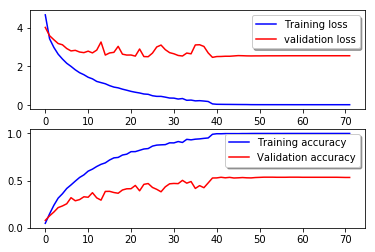

In [14]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [15]:
import pandas as pd
results = model.predict(X_test)
results = np.argmax(results,axis = 1)
names = list(le.inverse_transform(results))
file_names = list(data_test.keys())
names = pd.Series(names,name="celebrity_name")
submission = pd.concat([pd.Series(file_names,name = "image_label"),names],axis = 1)

submission.to_csv("celeberty_prediction.csv",index=False)